In [20]:
%pip install pandas sklearn shap seaborn graphviz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import pandas as pd, shap, seaborn as sns, graphviz, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn import tree
from matplotlib import pyplot as plt

### Load Data

In [22]:
#Students performance on a course on Buraimi University College (BUC), Sultanate of Oman
dataset = pd.read_csv(
    "./Datasets/An artificial intelligence approach to monitor student performance and devise preventive measures/data.csv",
    header=None,
    names=["Gen", "Attendance", "Major", "Year","Session","Exam1Grade","CGPA","Sponsorship","Dorm","PreReq_Grades","Class"])
dataset.head()
dataset.shape

(151, 11)

### Get data distributions

<AxesSubplot:title={'center':'Gender (0:Male, 1:Female)'}, ylabel='Frequency'>

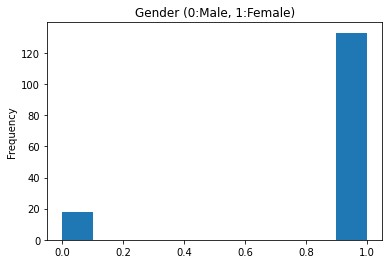

In [23]:
#Gender values distribution
dataset.Gen.apply(lambda x: 0 if x=='M' else 1).plot(kind='hist',title="Gender (0:Male, 1:Female)")

Note: Most of the students are female

<AxesSubplot:title={'center':'Major (0:Literature, 1:Translation)'}, ylabel='Frequency'>

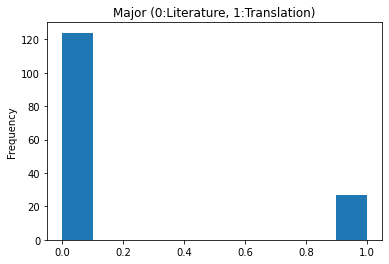

In [24]:
#Major values distribution
dataset.Major.apply(lambda x: 0 if x=='Literature' else 1).plot(kind='hist',title="Major (0:Literature, 1:Translation)")

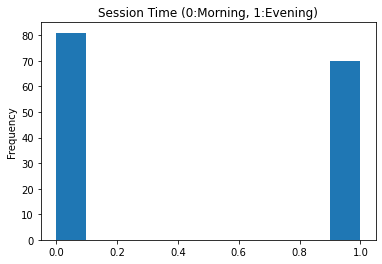

In [25]:
#Session values distribution
ax = dataset.Session.apply(lambda x: 0 if x=='Morning' else 1).plot(kind='hist',title="Session Time (0:Morning, 1:Evening)")

<AxesSubplot:title={'center':'Attendance'}, ylabel='Frequency'>

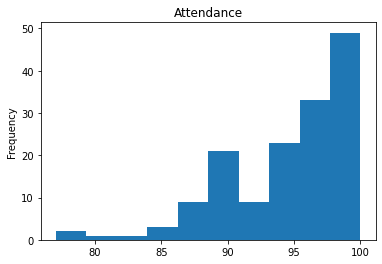

In [26]:
#Attendance values distribution
dataset.Attendance.plot(kind='hist',title="Attendance")

<AxesSubplot:title={'center':'Exam1Grade'}, ylabel='Frequency'>

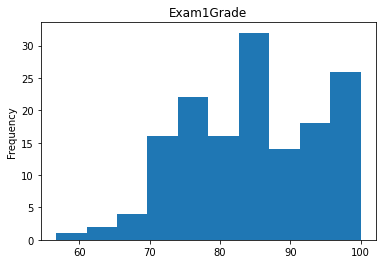

In [27]:
#Exam1Grade values distribution
dataset.Exam1Grade.plot(kind='hist',title="Exam1Grade")

<AxesSubplot:title={'center':'CGPA'}, ylabel='Frequency'>

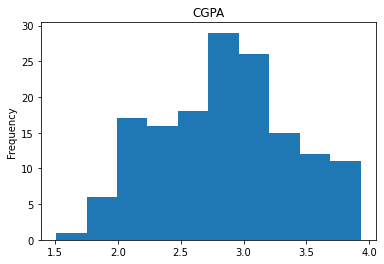

In [28]:
#CGPA values distribution
dataset.CGPA.plot(kind='hist',title="CGPA")

<AxesSubplot:title={'center':'PreReqGrades'}, ylabel='Frequency'>

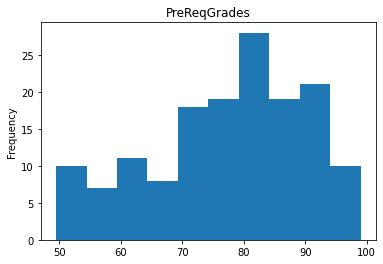

In [29]:
#PreReq_Grades values distribution
dataset.PreReq_Grades.plot(kind='hist',title="PreReqGrades")

<AxesSubplot:title={'center':'Class (0:Fail,1:Pass)'}, ylabel='Frequency'>

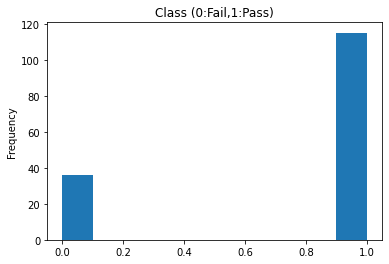

In [30]:
#Class values distribution
dataset.Class.apply(lambda x: 0 if x=='Low' else 1).plot(kind='hist',title="Class (0:Fail,1:Pass)")

/!\ We can see that we have a class imbalance in our data that we need to handle later /!\

### Transform Data

In [35]:
transformed_dataset = dataset
encode_columns = [
    "Gen",
    "Session",
    "Major",
    "Sponsorship",
    "Dorm"
]
for c in encode_columns:
    one_hot = pd.get_dummies(dataset[c],prefix=f"{c}_") #Only to values in one-hot drop one column
    transformed_dataset = transformed_dataset.join(one_hot.drop(one_hot.columns[0],axis=1)).drop(c,axis=1)

#Scale percentages in range [0,1]
scale_percentages = [
    "Attendance",
    "Exam1Grade",
    "PreReq_Grades"
]
for c in scale_percentages:
    transformed_dataset[c] = transformed_dataset[c] / 100

#Scale CGPA in range [0,1]
transformed_dataset.CGPA = transformed_dataset.CGPA / 4

transformed_dataset.Year = transformed_dataset.Year.apply(lambda x: int(x.replace("Year",""))) #Student Passed (dataset class)


#Encode class :
transformed_dataset.Class = transformed_dataset.Class.apply(lambda x: 0 if x=='Low' else 1) #Student Passed (dataset class)
transformed_dataset.head()

SyntaxError: invalid syntax (1618881779.py, line 25)

### Prepare Training and Test sets

In [32]:
#Get 80% of data for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(transformed_dataset.drop("Class",axis=1),transformed_dataset.Class,test_size=0.2,random_state=42)
y_train.value_counts()

1    92
0    28
Name: Class, dtype: int64

In [33]:
#Upscale minority class
df = X_train.join(y_train)
df_minor = df[df.Class==0]
df_major = df[df.Class==1]
majority_class_count = len(df_major)
minority_class_count = len(df_minor)
print(f"Class counts:\n > Minor class (Fail): {minority_class_count}\n > Major Class (Pass): {majority_class_count}\n > Total data: {minority_class_count+majority_class_count}")
df_minor_upscale = resample(df_minor, replace=True, n_samples=majority_class_count, random_state=42)
df = pd.concat([df_major,df_minor_upscale])
print(f"\nData count after upscaling: {len(df)}")
X_train = df.drop("Class",axis=1)
y_train = df.Class
print("\nFinal class counts:")
print(y_train.value_counts())

Class counts:
 > Minor class (Fail): 28
 > Major Class (Pass): 92
 > Total data: 120

Data count after upscaling: 184

Final class counts:
1    92
0    92
Name: Class, dtype: int64


### Train models

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


models = [
    ['RandomForest',RandomForestClassifier(n_estimators=200, max_depth=4, criterion="gini", n_jobs=-1, random_state=42),None],
    ['DecisionTree',DecisionTreeClassifier(max_depth=4, criterion="gini", random_state=42),None],
    ['LinearRegression',LinearRegression(),None],
    ['MLPRegressor',MLPClassifier(hidden_layer_sizes=(100,), activation="tanh", max_iter=10000, random_state=42),None]
    #More models to be implemented
]

for i in range(len(models)):
    print(models[i][0])
    models[i][1].fit(X_train, y_train)
    models[i][2] = models[i][1].predict(X_test) #Predictions
    models[i][2] = [round(x) for x in models[i][2]]
    print(classification_report(models[i][2],y_test))


RandomForest


ValueError: could not convert string to float: 'Year2'

### Feature Importance

##### RandomForest

AttributeError: 'RandomForestClassifier' object has no attribute 'estimators_'

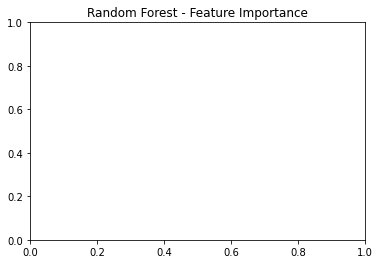

In [ ]:
rf = models[0][1]
plt.title("Random Forest - Feature Importance")
sns.barplot(y=X_train.columns,x=rf.feature_importances_, orient='h')

In [ ]:
cm = confusion_matrix(y_test, models[0][2], labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

ValueError: Expected array-like (array or non-string sequence), got None

##### Decision Tree

In [ ]:
dt = models[1][1]
tree.export_graphviz(dt, out_file="tree.dot", class_names=["FAIL", "PASS"],feature_names=list(X_train.columns), impurity=False, filled=True)
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
sns.barplot(y=X_train.columns,x=dt.feature_importances_, orient='h')

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
cm = confusion_matrix(y_test, models[1][2], labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

ValueError: Expected array-like (array or non-string sequence), got None

##### Linear Regression

<AxesSubplot:title={'center':'Linear Regression - Feature Importance'}>

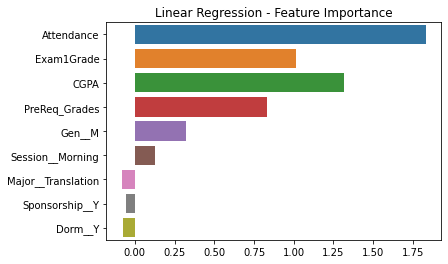

In [ ]:
lr = models[2][1]
plt.title("Linear Regression - Feature Importance")
sns.barplot(y=X_train.columns,x=lr.coef_, orient='h')

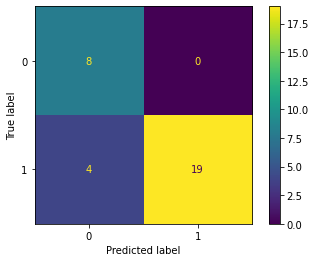

In [ ]:
cm = confusion_matrix(y_test, models[2][2], labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

##### MLP

<AxesSubplot:title={'center':'Multi Layer Perceptron - Feature Importance'}>

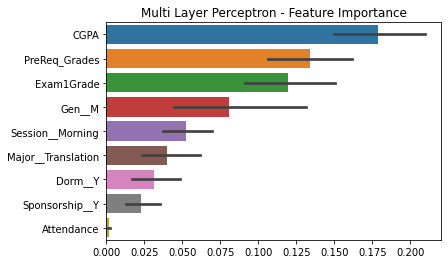

In [ ]:
shap.initjs()
x = X_test
explainer = shap.Explainer(models[3][1].predict,x)
shap_test = explainer(x)
shap_values = pd.DataFrame(shap_test.values,
                       columns=shap_test.feature_names,
                       index=x.index)
plt.title("Multi Layer Perceptron - Feature Importance")
columns = shap_values.apply(abs).mean()\
                 .sort_values(ascending=False).index
sns.barplot(data=shap_values[columns].apply(abs), orient='h')